# Monte-Carlo-Simulation

### Config

In [1]:
PATH = "./example_portfolio.csv"
RHO = 0.2
N_SIMS = 10_000
SEED = 79
q = 0.999

### Modules

In [2]:
import ctypes
import matplotlib.pyplot as plt
import numpy as np

### C-Interface

In [3]:
class Config(ctypes.Structure):
    _fields_ = [
        ("path", ctypes.c_char * 1024),
        ("rho", ctypes.c_float),
        ("n_sims", ctypes.c_size_t),
        ("seed", ctypes.c_uint)
    ]

class Result(ctypes.Structure):
    _fields_ = [
        ("ms", ctypes.c_float),
        ("L_PF", ctypes.POINTER(ctypes.c_float)),
        ("LR_PF", ctypes.POINTER(ctypes.c_float)),
        ("exact_EL", ctypes.c_float),
        ("EL", ctypes.c_float),
        ("exact_UL", ctypes.c_float),
        ("UL", ctypes.c_float),
        ("portfolio_size", ctypes.c_size_t),
        ("n_sims", ctypes.c_size_t)
    ]

libmonte = ctypes.CDLL("./libmerton.so")
libmonte.simulate.argtypes = [Config]
libmonte.simulate.restype = Result

### Simulation

In [4]:
config = Config(PATH.encode("utf-8"), RHO, N_SIMS, SEED)
result = libmonte.simulate(config)
l_pf = [float(result.L_PF[i]) for i in range(result.n_sims)]
lr_pf = [float(result.LR_PF[i]) for i in range(result.n_sims)]

print(f"{N_SIMS} simulations took {result.ms:.2f} ms")
print(f"path: {PATH}")
print(f"exact EL: {result.exact_EL:.2f} €")
print(f"EL: {result.EL:.2f} €")
print(f"exact UL: {result.exact_UL:.2f} €")
print(f"UL: {result.UL:.2f} €")
print(f"portfolio_size: {result.portfolio_size}")

10000 simulations took 40.96 ms
path: ./example_portfolio.csv
exact EL: 928200.00 €
EL: 933600.00 €
exact UL: 2355868.00 €
UL: 3139344.75 €
portfolio_size: 80


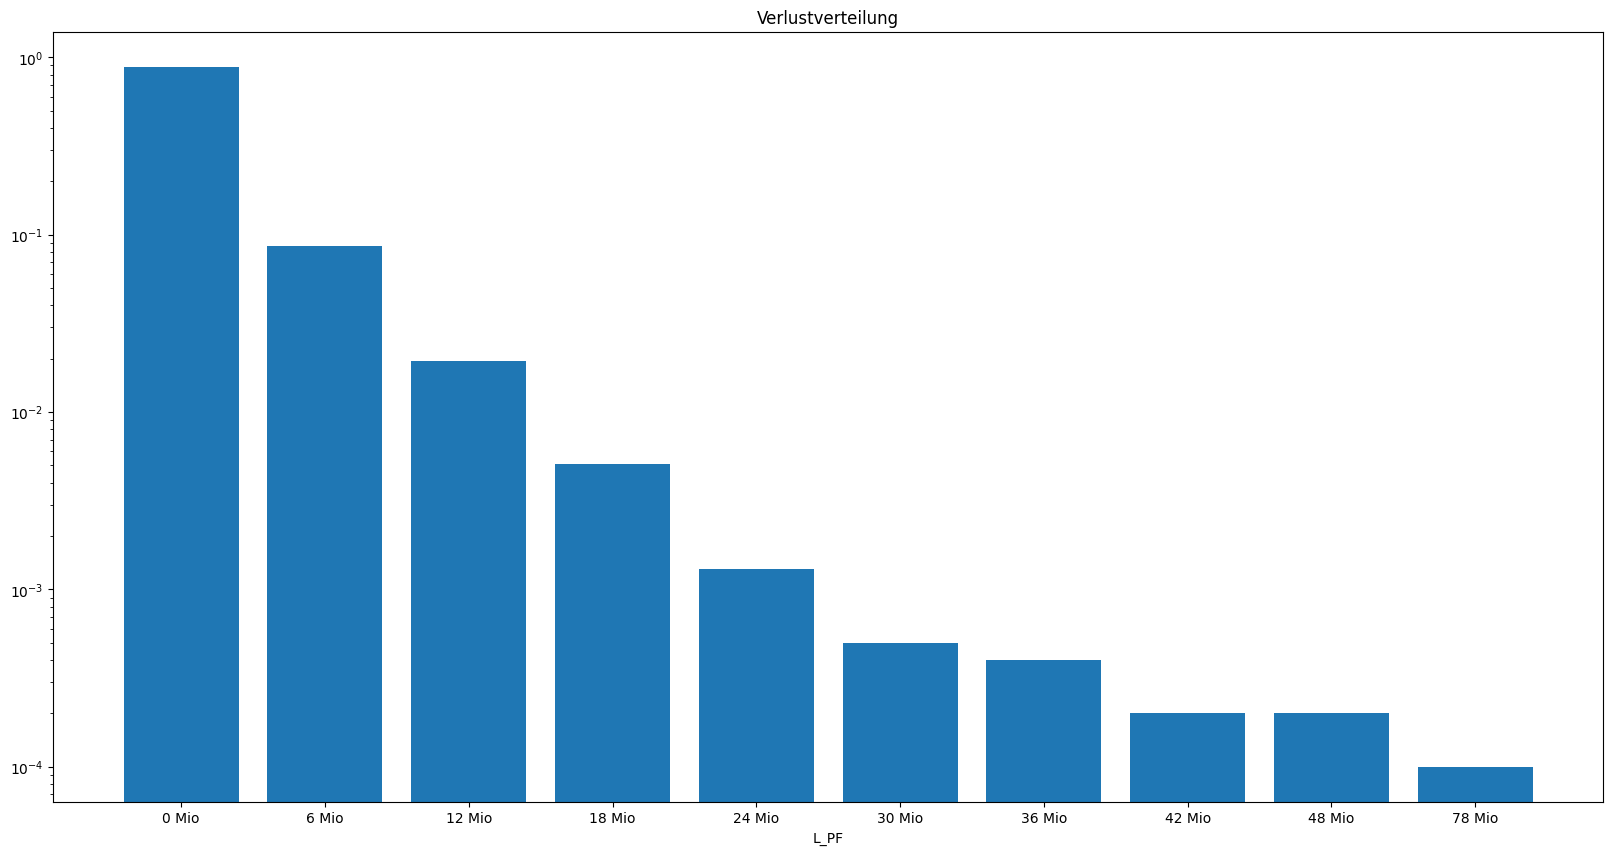

In [5]:
x, y = np.unique(l_pf, return_counts=True)
rel_amount = y/np.sum(y)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_yscale("log")
ax.set_title(f"Verlustverteilung")
names = [f"{int(e/1_000_000)} Mio" for e in x]
ax.bar(names, rel_amount)
ax.set_xlabel("L_PF")
plt.show()

In [6]:
VaR = None

print("table")
for bin, p in zip(x, np.cumsum(rel_amount)):
    print(bin, p*100)
    if p >= q and VaR is None:
        VaR = bin

EC = VaR - result.EL

print()
print(f"{VaR=}")
print(f"EC={EC}")

table
0.0 88.58
6000000.0 97.27
12000000.0 99.22
18000000.0 99.72999999999999
24000000.0 99.86
30000000.0 99.90999999999998
36000000.0 99.94999999999999
42000000.0 99.96999999999998
48000000.0 99.98999999999998
78000000.0 99.99999999999997

VaR=30000000.0
EC=29066400.0
